In [1]:
# load variables
%store -r gi_32
%store -r gi_64
%store -r gi_128
%store -r gi_256
%store -r gi_512

In [48]:
class MultiArmedBandits:
    def __init__(self, k = 10, epsilon = 0, initial = 0, true_expected_reward = 0, step_size = None, ucb = None, 
                 gradient = None, baseline = None, thompson = None, bayes_ucb = None, gittins = None, 
                 num_steps = 1000, num_runs = 2000):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.initial_mu = true_expected_reward
        self.step_size = step_size
        self.ucb_c = ucb # degree of exploration
        self.gradient = gradient # step_size for gradient bandit algorithm
        self.baseline = baseline
        self.thompson = thompson
        self.bayes_ucb_c = bayes_ucb
        self.gi_values = gittins
        self.num_steps = num_steps
        self.num_runs = num_runs
        
        
    def new_bandit(self):
        self.q = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k).astype(int)
        self.mu = np.random.randn(self.k) + self.initial_mu
        self.action_optimal = np.argmax(self.mu)
        self.reward_episode = np.zeros(self.num_steps)
        self.action_episode = np.zeros(self.num_steps)
        if self.gradient:
            self.h = np.zeros(self.k)
            self.prev_rewards_bar = 0
            self.rewards_bar = 0
        if self.thompson or self.bayes_ucb_c:  # flat prior
            self.estimated_mu = np.zeros(self.k)
            self.estimated_var = np.zeros(self.k) + 1
        
            
        
    # default: 1000 steps make up one episode/run    
    def episode(self):
        for step in range(self.num_steps):
            
            # choose action
            if np.random.random() < self.epsilon: # choose randomly
                action = np.random.randint(1,self.k)
            elif self.ucb_c:
                if min(self.action_count) == 0:
                    action = np.argmin(self.action_count)
                else:
                    ucb_action = self.q + self.ucb_c * np.sqrt(np.divide(np.log(step + 1), self.action_count))
                    action = np.argmax(ucb_action)
            elif self.gradient: # gradient bandit: only consider numerical preference
                h_exp = np.exp(self.h)
                pi = h_exp / np.sum(h_exp)
                action = np.random.choice(np.arange(self.k), p = pi)
            elif self.thompson:
                samples = np.random.normal(self.estimated_mu, np.sqrt(self.estimated_var))
                action = np.random.choice(np.where(samples == max(samples))[0])
            elif self.bayes_ucb_c:
                self.q = norm.ppf(1 - 1 / ((step + 1) * pow(np.log(self.num_steps), self.bayes_ucb_c)), 
                                  self.estimated_mu, np.sqrt(self.estimated_var))
                action = np.random.choice(np.where(self.q == max(self.q))[0])
            elif self.gi_values != None:
                gi = self.q + self.gi_values[self.action_count]
                action = np.random.choice(np.where(gi == max(gi))[0])
            else:
                action = np.argmax(self.q)  
            
            
            # update action
            self.action_count[action] += 1
            if action == self.action_optimal:
                self.action_episode[step] = 1

                
            # receive rewards
            reward = np.random.randn() + self.mu[action]
            self.reward_episode[step] = reward
            
            
            # update parameters
            if self.step_size:
                self.q[action] += self.step_size * (reward - self.q[action])  # constant step-size
            elif self.gradient:
                h_action = np.zeros(self.k)
                h_action[action] = 1
                if self.baseline: # if no baseline, q is constantly 0
                    self.rewards_bar += (reward - self.rewards_bar) / (step + 1) # average of all rewards
                self.h += self.gradient * (reward - self.rewards_bar) * (h_action - pi) # update h, eq. 2.12 stochastic gradient ascent              
            elif self.thompson or self.bayes_ucb_c:
                self.estimated_mu[action] += (reward - self.estimated_mu[action]) / (self.action_count[action] + 1)
                self.estimated_var[action] = 1 / (self.action_count[action] + 1)
            elif self.gi_values != None:
                self.q[action] += (reward - self.q[action]) / (self.action_count[action] + 1)  # sample average with N(0,1) prior
            else: 
                self.q[action] += (reward - self.q[action]) / self.action_count[action]  # sample average
        return self.reward_episode, self.action_episode
    
    # default: average of 2000 runs
    def simulate(self):
        average_reward = np.zeros((self.num_runs, self.num_steps))
        action_percentage = np.zeros((self.num_runs, self.num_steps))
        for run in tqdm(range(self.num_runs)):
            self.new_bandit()
            average_reward[run], action_percentage[run] = self.episode()
        return [np.mean(average_reward, axis = 0), np.mean(action_percentage, axis = 0), np.mean(average_reward, axis = 1)]

## horizon = n = 32, \gamma = 0.96875 = 1-1/n

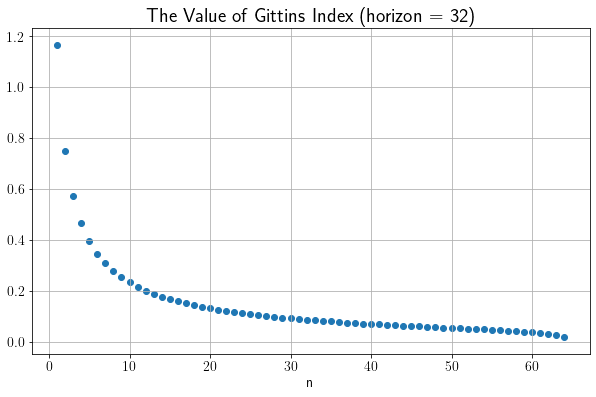

In [63]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 32)", fontsize = 20)
plt.grid()
plt.show()

In [17]:
gittins_steps32_runs1000000 = MultiArmedBandits(gittins = gi_32, num_steps = 32, num_runs = 1000000).simulate()

In [18]:
thompson_steps32_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 32, num_runs = 1000000).simulate()

In [19]:
print("Gittins Index mean: " + str(np.mean(gittins_steps32_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps32_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps32_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps32_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 1.010039168441185
Gittins Index std: 0.0006593061284972354
Thompson Sampling mean: 0.7691286838148467
Thompson Sampling std: 0.0006210414461636757


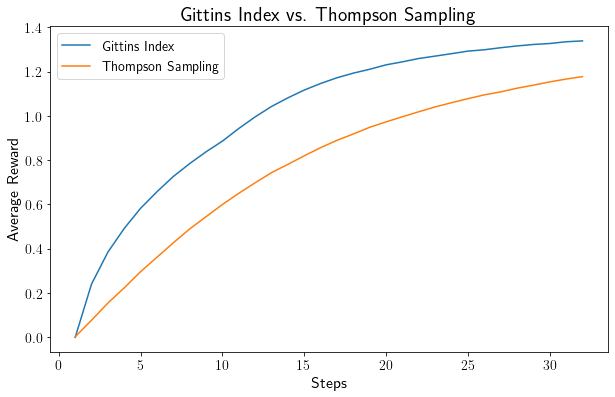

In [44]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

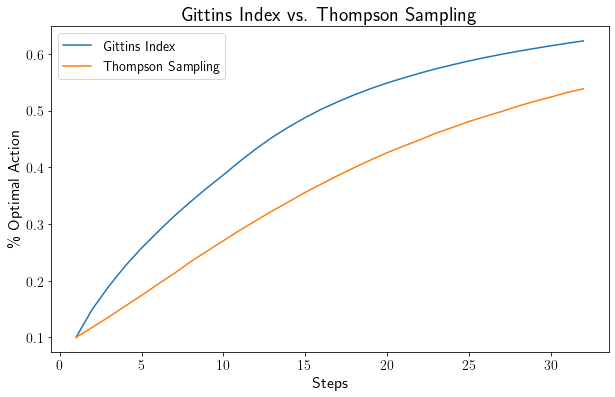

In [45]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 32 + 1)), gittins_steps32_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 32 + 1)), thompson_steps32_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 64, \gamma = 0.984375 = 1-1/n

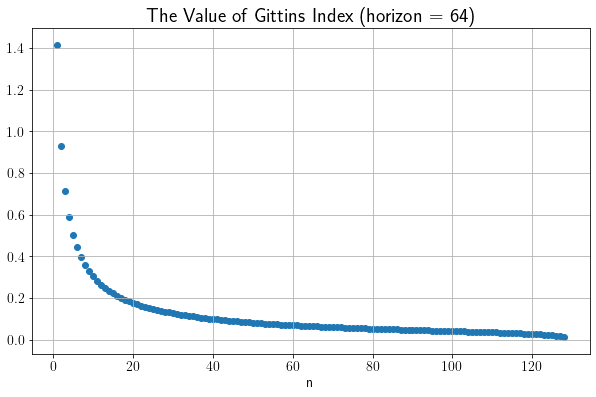

In [73]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 64)", fontsize = 20)
plt.grid()
plt.show()

In [24]:
gittins_steps64_runs1000000 = MultiArmedBandits(gittins = gi_64, num_steps = 64, num_runs = 1000000).simulate()
thompson_steps64_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 64, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps64_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps64_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps64_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps64_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 1.197793669418486
Gittins Index std: 0.0006339655452577602
Thompson Sampling mean: 1.0294364485061784
Thompson Sampling std: 0.000622974087886675


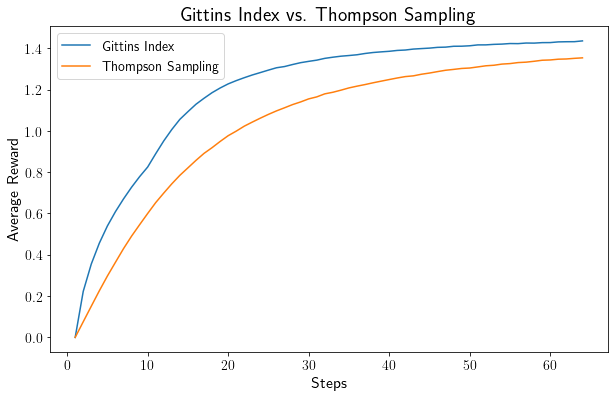

In [25]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 64 + 1)), thompson_steps64_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

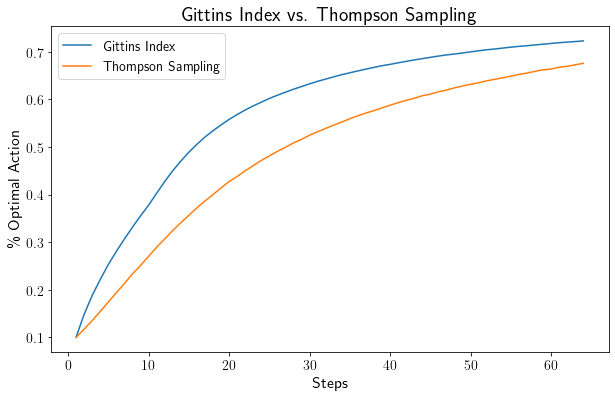

In [26]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 64 + 1)), gittins_steps64_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 64 + 1)), thompson_steps64_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 128, \gamma = 0.9921875 = 1-1/n

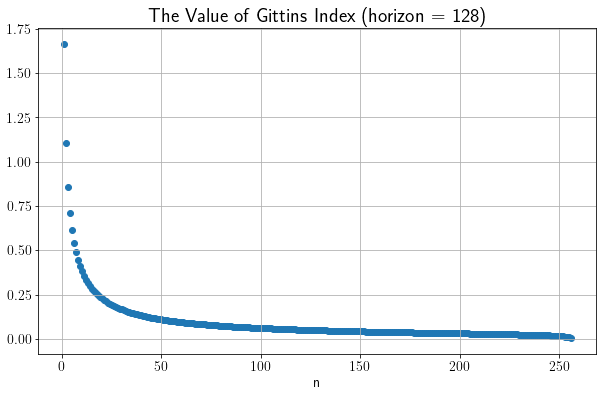

In [59]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 128)", fontsize = 20)
plt.grid()
plt.show()

In [27]:
gittins_steps128_runs1000000 = MultiArmedBandits(gittins = gi_128, num_steps = 128, num_runs = 1000000).simulate()
thompson_steps128_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 128, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps128_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps128_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps128_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps128_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 1.3278692629043691
Gittins Index std: 0.0006210993963152366
Thompson Sampling mean: 1.2193952912627086
Thompson Sampling std: 0.0006242979105036366


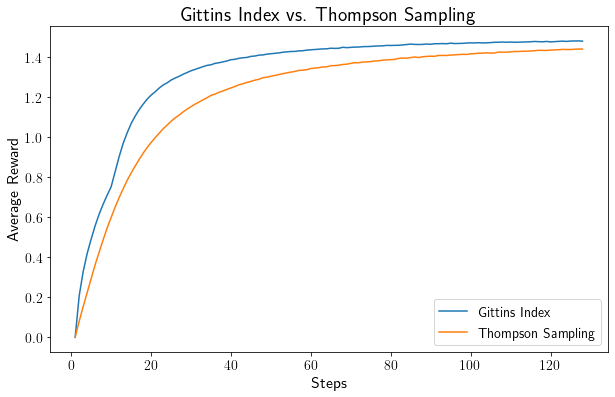

In [28]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 128 + 1)), thompson_steps128_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

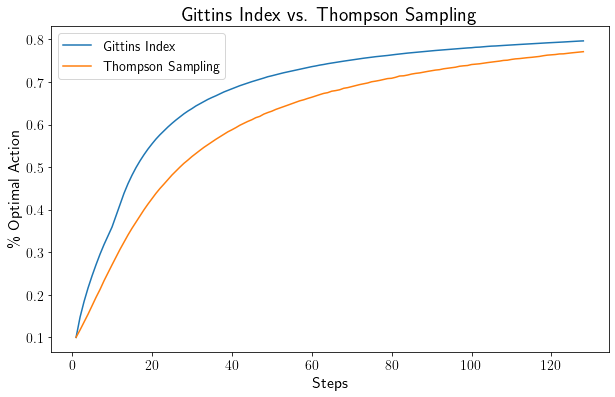

In [29]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 128 + 1)), gittins_steps128_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 128 + 1)), thompson_steps128_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 256, \gamma = 0.99609375 = 1-1/n

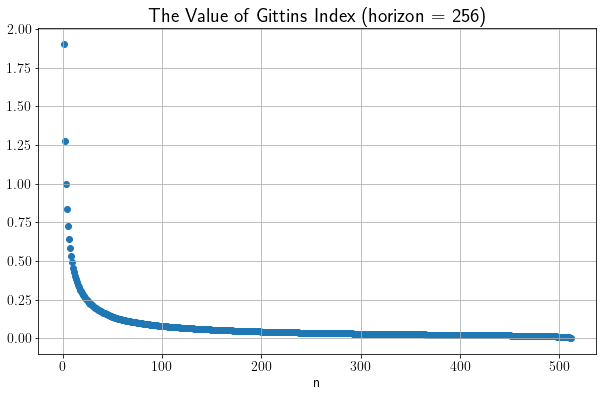

In [48]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 256)", fontsize = 20)
plt.grid()
plt.show()

In [30]:
gittins_steps256_runs1000000 = MultiArmedBandits(gittins = gi_256, num_steps = 256, num_runs = 1000000).simulate()
thompson_steps256_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 256, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps256_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps256_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps256_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps256_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 1.4107013193065447
Gittins Index std: 0.0006113274708479579
Thompson Sampling mean: 1.344858652900465
Thompson Sampling std: 0.0006175761675034211


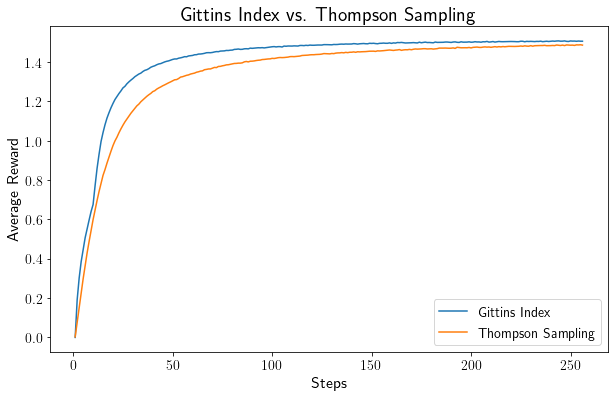

In [31]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 256 + 1)), gittins_steps256_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 256 + 1)), thompson_steps256_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

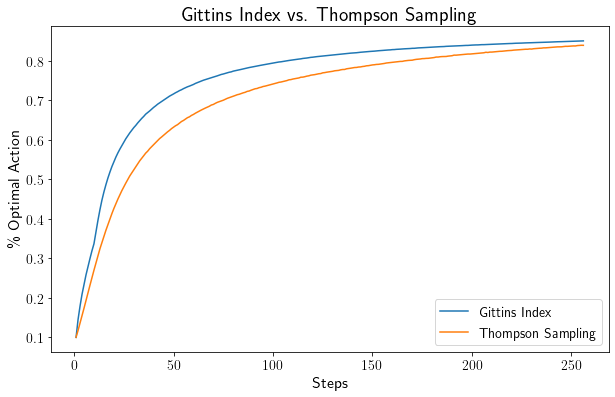

In [32]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 256 + 1)), gittins_steps256_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 256 + 1)), thompson_steps256_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

## horizon = n = 512, \gamma = 0.998046875 = 1-1/n

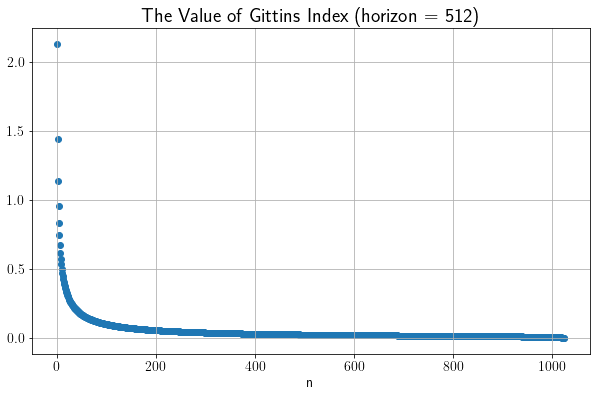

In [81]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(list(range(1, N + 1)), roots)
plt.xlabel("n")
plt.title(r"The Value of Gittins Index (horizon = 512)", fontsize = 20)
plt.grid()
plt.show()

In [33]:
gittins_steps512_runs1000000 = MultiArmedBandits(gittins = gi_512, num_steps = 512, num_runs = 1000000).simulate()
thompson_steps512_runs1000000 = MultiArmedBandits(thompson = True, num_steps = 512, num_runs = 1000000).simulate()
print("Gittins Index mean: " + str(np.mean(gittins_steps512_runs1000000[2])))
print("Gittins Index std: " + str(np.std(gittins_steps512_runs1000000[2])/np.sqrt(1000000)))
print("Thompson Sampling mean: " + str(np.mean(thompson_steps512_runs1000000[2])))
print("Thompson Sampling std: " + str(np.std(thompson_steps512_runs1000000[2])/np.sqrt(1000000)))


Gittins Index mean: 1.4627069090021738
Gittins Index std: 0.0006032236483978317
Thompson Sampling mean: 1.4222422048506609
Thompson Sampling std: 0.000609152467549521


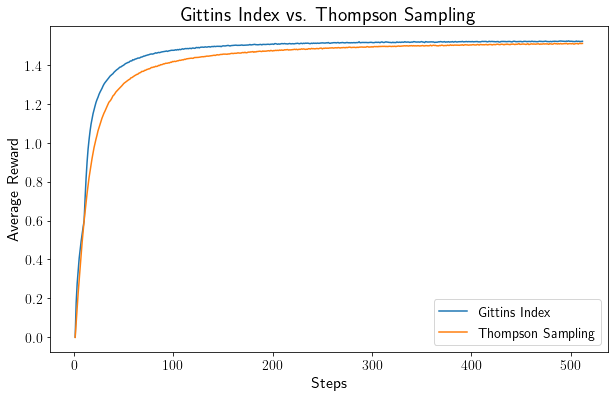

In [34]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 512 + 1)), gittins_steps512_runs1000000[0], label="Gittins Index")
plt.plot(list(range(1, 512 + 1)), thompson_steps512_runs1000000[0], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("Average Reward", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()

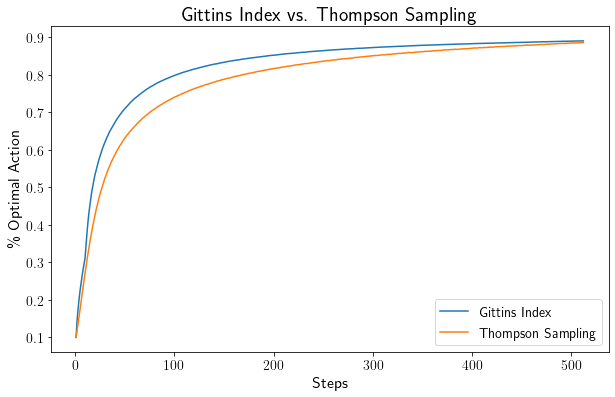

In [35]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.plot(list(range(1, 512 + 1)), gittins_steps512_runs1000000[1], label="Gittins Index")
plt.plot(list(range(1, 512 + 1)), thompson_steps512_runs1000000[1], label="Thompson Sampling")
plt.xlabel("Steps", fontsize = 16)
plt.ylabel("\% Optimal Action", fontsize = 16)
plt.title("Gittins Index vs. Thompson Sampling", fontsize = 20)
plt.legend()